In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
df = pd.read_csv('./data/okcupid_preprocessed_copy.csv')
df = df.drop('Unnamed: 0', axis=1)

In [49]:
df.columns

Index(['sex', 'drinks', 'drugs', 'education', 'height', 'job', 'last_online',
       'smokes', 'Response rate', 'age', 'diet', 'total_essay_len',
       'essay_answered_count', 'is_churned', 'orientation_1', 'job_score',
       'stability_index', 'sign_1', 'body_type_average', 'body_type_curvy',
       'body_type_fit', 'body_type_slim', 'religion_religion',
       'status_encoding', 'ethnicity_black', 'ethnicity_hispanic / latin',
       'ethnicity_mixed', 'ethnicity_other', 'ethnicity_white',
       'dogs_encoding', 'cats_encoding', 'location_group_north_bay',
       'location_group_outside', 'location_group_sf',
       'location_group_south_bay', 'niche_score'],
      dtype='object')

In [50]:
df.head()

,sex,drinks,drugs,education,height,job,last_online,smokes,Response rate,age,...,ethnicity_mixed,ethnicity_other,ethnicity_white,dogs_encoding,cats_encoding,location_group_north_bay,location_group_outside,location_group_sf,location_group_south_bay,niche_score
0,1,0.0,0,1.0,75.0,transportation,2012-06-28,1.0,1.000000,22,...,True,False,False,1,1,False,False,False,True,6.0
1,1,1.0,1,NaN,70.0,hospitality / travel,2012-06-29,0.0,0.870968,35,...,False,False,True,1,1,False,False,False,False,3.0
2,1,0.0,0,3.0,68.0,NaN,2012-06-27,0.0,0.806452,38,...,False,False,False,0,1,False,False,True,False,0.0
3,1,0.0,0,1.0,71.0,student,2012-06-28,0.0,0.838710,23,...,False,False,True,0,1,False,False,False,False,1.0
4,1,0.0,0,2.0,66.0,artistic / musical / writer,2012-06-27,0.0,0.741935,29,...,True,False,False,1,1,False,False,True,False,0.0


In [51]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score

In [52]:
X = df.drop(['is_churned', 'last_online', 'ethnicity_black', 'ethnicity_hispanic / latin', 'ethnicity_mixed',
       'ethnicity_other', 'ethnicity_white', 'dogs_encoding', 'cats_encoding','location_group_north_bay', 'location_group_outside',
       'location_group_sf', 'location_group_south_bay', 'job', 'stability_index'], axis=1) 
y = df['is_churned']

In [53]:
X.columns

Index(['sex', 'drinks', 'drugs', 'education', 'height', 'smokes',
       'Response rate', 'age', 'diet', 'total_essay_len',
       'essay_answered_count', 'orientation_1', 'job_score', 'sign_1',
       'body_type_average', 'body_type_curvy', 'body_type_fit',
       'body_type_slim', 'religion_religion', 'status_encoding',
       'niche_score'],
      dtype='object')

In [54]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sex                   59934 non-null  int64  
 1   drinks                59934 non-null  float64
 2   drugs                 59934 non-null  int64  
 3   education             51629 non-null  float64
 4   height                59934 non-null  float64
 5   smokes                59934 non-null  float64
 6   Response rate         59934 non-null  float64
 7   age                   59934 non-null  int64  
 8   diet                  59934 non-null  int64  
 9   total_essay_len       59934 non-null  int64  
 10  essay_answered_count  59934 non-null  int64  
 11  orientation_1         59934 non-null  bool   
 12  job_score             59934 non-null  float64
 13  sign_1                59934 non-null  bool   
 14  body_type_average     59934 non-null  bool   
 15  body_type_curvy    

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [56]:
# XGBoost 모델 설정 변경
xgb_model = XGBClassifier(
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss',
    scale_pos_weight=1.49  # 이 부분이 핵심!
)

xgb_model.fit(X_train, y_train)

# 다시 평가해보기
print("--- [optuna 적용 전 XGBoost 결과] ---")
print(classification_report(y_test, xgb_model.predict(X_test)))

--- [optuna 적용 전 XGBoost 결과] ---
              precision    recall  f1-score   support

           0       0.73      0.81      0.77      7983
           1       0.52      0.41      0.46      4004

    accuracy                           0.68     11987
   macro avg       0.63      0.61      0.61     11987
weighted avg       0.66      0.68      0.66     11987



In [57]:
import optuna
import numpy as np
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score

def objective(trial):
    param = {
        'n_estimators': 1000, # 크게 잡고 early_stopping으로 끊습니다.
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.5, 4.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'random_state': 42,
        'eval_metric': 'logloss',
        'n_jobs': -1
    }

    # 5-Fold 교차 검증 설정
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = XGBClassifier(**param, early_stopping_rounds=50)
        
        # early_stopping_rounds 적용 (XGBoost 1.6+ 버전 방식)
        model.fit(X_t, y_t, 
                  eval_set=[(X_v, y_v)], 
                  verbose=False)
        
        
        y_prob_val = model.predict_proba(X_v)[:, 1]
        score = average_precision_score(y_v, y_prob_val) # PR-AUC 점수
        cv_scores.append(score)

    return np.mean(cv_scores)

# 학습 시작
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective, n_trials=50) # CV는 시간이 걸리므로 50회부터 시작 추천

print(f"최적의 혼합 F1 점수: {study_xgb.best_value}")
print(f"최적의 파라미터: {study_xgb.best_params}")

# 최적 파라미터로 최종 모델 학습
best_model = XGBClassifier(**study_xgb.best_params)
best_model.fit(X_train, y_train)

print("--- [새로운 Optuna 최적화 결과] ---")
print(classification_report(y_test, best_model.predict(X_test)))

[I 2026-02-24 10:31:28,921] A new study created in memory with name: no-name-eff835a5-097b-4eb3-a4b7-81a6ed12acb9
[I 2026-02-24 10:31:34,742] Trial 0 finished with value: 0.5206708421817308 and parameters: {'max_depth': 7, 'learning_rate': 0.03281914022107772, 'gamma': 0.3869666816299655, 'subsample': 0.6432151439528665, 'colsample_bytree': 0.848922161103775, 'scale_pos_weight': 1.6458796613584528, 'reg_alpha': 0.0017754462049337832, 'reg_lambda': 0.023313136943228313}. Best is trial 0 with value: 0.5206708421817308.
[I 2026-02-24 10:31:50,209] Trial 1 finished with value: 0.5236114422220876 and parameters: {'max_depth': 5, 'learning_rate': 0.010419428960826337, 'gamma': 0.9682854007730348, 'subsample': 0.6855936731618335, 'colsample_bytree': 0.8449488834299713, 'scale_pos_weight': 3.445132559385233, 'reg_alpha': 0.010101200017472996, 'reg_lambda': 0.7208476053765359}. Best is trial 1 with value: 0.5236114422220876.
[I 2026-02-24 10:31:56,000] Trial 2 finished with value: 0.52207111394

최적의 혼합 F1 점수: 0.5258494153986238
최적의 파라미터: {'max_depth': 4, 'learning_rate': 0.03183316403419217, 'gamma': 0.8713648146508266, 'subsample': 0.6329519406950884, 'colsample_bytree': 0.8478338262838837, 'scale_pos_weight': 1.6363781535975113, 'reg_alpha': 4.862086274234989, 'reg_lambda': 2.5428177659080693}
--- [새로운 Optuna 최적화 결과] ---
              precision    recall  f1-score   support

           0       0.74      0.81      0.77      7983
           1       0.52      0.42      0.47      4004

    accuracy                           0.68     11987
   macro avg       0.63      0.62      0.62     11987
weighted avg       0.67      0.68      0.67     11987



In [76]:
from sklearn.metrics import precision_recall_curve
# XGBoost 모델로 확률 예측 (best_model이 XGBoost라고 가정)
y_probs_xgb = best_model.predict_proba(X_test)[:, 1]

# Precision, Recall, Threshold 리스트 추출
precisions_xgb, recalls_xgb, thresholds_xgb = precision_recall_curve(y_test, y_probs_xgb)

# F1-score 계산 ($$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$)
f1_scores_xgb = 2 * (precisions_xgb * recalls_xgb) / (precisions_xgb + recalls_xgb + 1e-9)
best_idx_xgb = np.argmax(f1_scores_xgb)
best_th_xgb = thresholds_xgb[best_idx_xgb]

print(f"XGBoost의 최적 임계값: {best_th_xgb:.4f}")

# 결과 출력
final_preds_xgb = (y_probs_xgb >= best_th_xgb).astype(int)
print("--- [XGBoost 임계값 조정 후 최종 결과] ---")
print(classification_report(y_test, final_preds_xgb))

XGBoost의 최적 임계값: 0.3899
--- [XGBoost 임계값 조정 후 최종 결과] ---
              precision    recall  f1-score   support

           0       0.80      0.49      0.61      7983
           1       0.43      0.76      0.55      4004

    accuracy                           0.58     11987
   macro avg       0.61      0.62      0.58     11987
weighted avg       0.68      0.58      0.59     11987



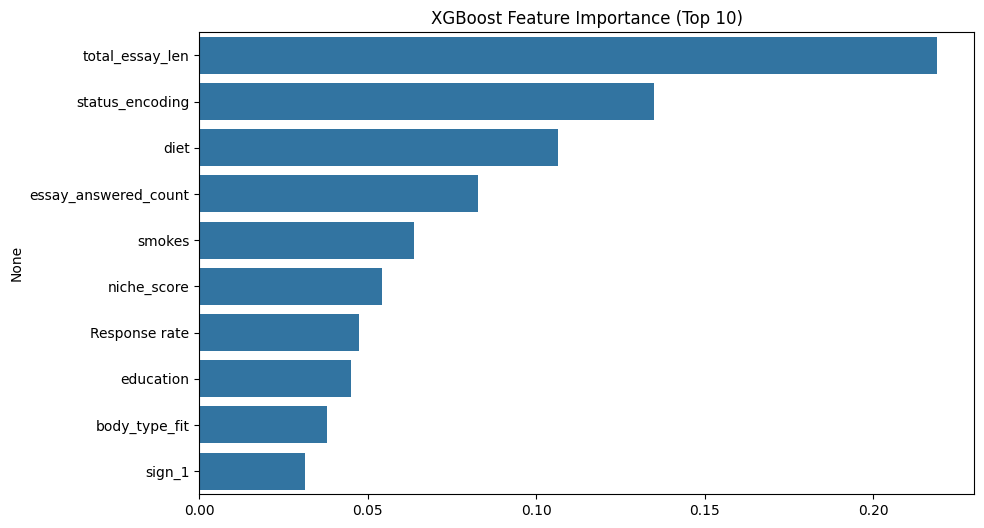

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost의 특성 중요도 추출
feature_imp = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp.head(10).values, y=feature_imp.head(10).index)
plt.title('XGBoost Feature Importance (Top 10)')
plt.show()

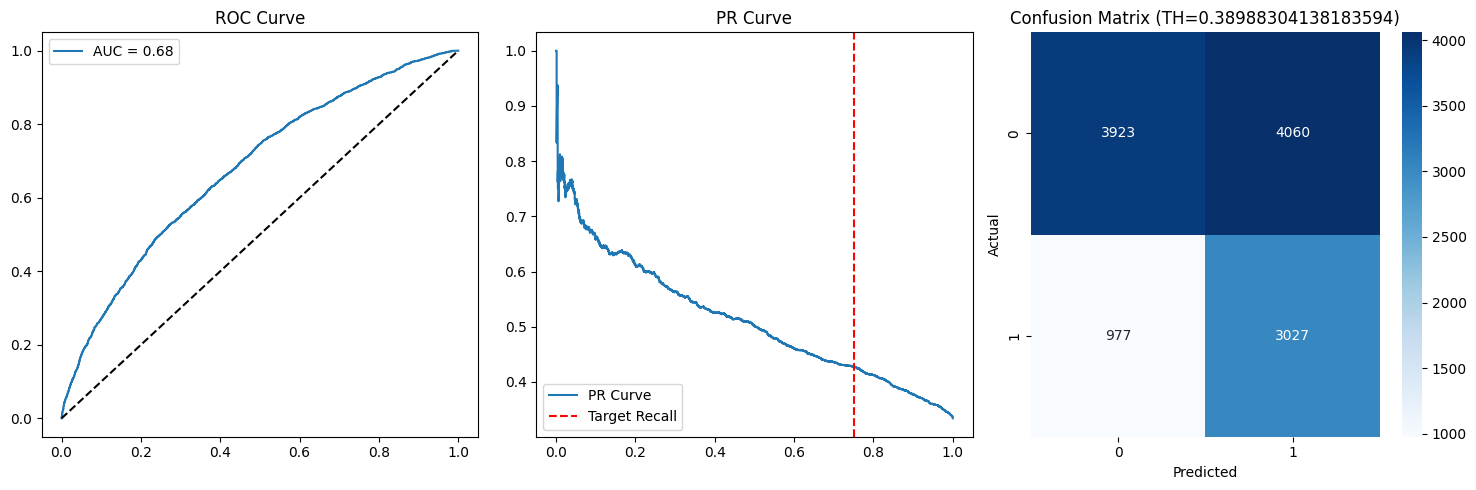

--- [임계값 0.38988304138183594 적용 최종 리포트] ---
              precision    recall  f1-score   support

           0       0.80      0.49      0.61      7983
           1       0.43      0.76      0.55      4004

    accuracy                           0.58     11987
   macro avg       0.61      0.62      0.58     11987
weighted avg       0.68      0.58      0.59     11987



In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report

# 1. 확률값 추출
y_probs = best_model.predict_proba(X_test)[:, 1]

# 2. 우리가 찾은 최적 임계값 적용
best_th = best_th_xgb
y_preds = (y_probs >= best_th).astype(int)

# 3. 시각화 세팅
plt.figure(figsize=(15, 5))

# ① ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.legend()

# ② Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_probs)
plt.subplot(1, 3, 2)
plt.plot(rec, prec, label='PR Curve')
plt.axvline(x=0.75, color='r', linestyle='--', label='Target Recall') # 아까의 Recall 지점
plt.title('PR Curve')
plt.legend()

# ③ Confusion Matrix (실제 임계값이 반영된 결과)
plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, y_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (TH={best_th})')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# 최종 성적표 출력
print(f"--- [임계값 {best_th} 적용 최종 리포트] ---")
print(classification_report(y_test, y_preds))

In [61]:
import pandas as pd
import numpy as np

# 1. 아직 이탈하지 않은(현재 활동 중인) 유저 데이터만 추출
active_users = df[df['is_churned'] == 0].copy()

# 2. 랜덤으로 10명 샘플링 (원하는 숫자로 조절 가능)
sample_users = active_users.sample(n=10)

# 3. 예측에 필요한 피처들만 추출 (X_train과 동일한 컬럼 순서여야 함)
X_sample = sample_users[X_train.columns]

# 4. predict_proba를 사용하여 이탈 확률(Class 1일 확률) 계산
# [:, 1]은 이탈할 확률(1)을 가져오겠다는 의미입니다.
sample_probs = best_model.predict_proba(X_sample)[:, 1]

# 5. 결과 데이터프레임 구성
sample_results = sample_users[['age', 'total_essay_len', 'niche_score', 'job_score']].copy()
sample_results['이탈_확률(%)'] = np.round(sample_probs * 100, 2)

# 6. 이탈 확률이 높은 순으로 출력
print("--- [미이탈 유저 대상 랜덤 샘플링 예측 결과] ---")
print(sample_results.sort_values(by='이탈_확률(%)', ascending=False))

--- [미이탈 유저 대상 랜덤 샘플링 예측 결과] ---
       age  total_essay_len  niche_score  job_score   이탈_확률(%)
32337   23              263          2.0        0.0  63.970001
1382    28              676          2.0        1.0  62.779999
53023   34               97          0.0        2.0  57.169998
50670   23              736          2.0        2.0  43.540001
18074   30             1509          0.0        2.0  43.189999
22368   20             2137         11.0        1.0  41.660000
1667    27             1069          5.0        0.0  39.869999
56835   20             1830          2.0        1.0  39.180000
11592   28             4292          3.0        3.0  31.780001
47210   25             2143          1.0        2.0  22.469999


In [62]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# 1. LightGBM 모델 초기화 및 학습
# is_unbalance=True: 클래스 불균형을 자동으로 가중치 조절
lgbm_model = LGBMClassifier(
    n_estimators=100,
    random_state=42,
    is_unbalance=True, # XGBoost의 scale_pos_weight와 비슷한 역할
    learning_rate=0.05,
    boosting_type='gbdt'
)
    
lgbm_model.fit(X_train, y_train)

# 2. 결과 예측
lgbm_pred = lgbm_model.predict(X_test)

# 3. 성능 평가
print("--- [optuna 적용 전 LightGBM 결과] ---")
print(classification_report(y_test, lgbm_pred))

--- [optuna 적용 전 LightGBM 결과] ---
              precision    recall  f1-score   support

           0       0.76      0.68      0.72      7983
           1       0.48      0.57      0.52      4004

    accuracy                           0.65     11987
   macro avg       0.62      0.63      0.62     11987
weighted avg       0.67      0.65      0.65     11987



In [63]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report
from lightgbm import early_stopping, log_evaluation
import warnings
warnings.filterwarnings('ignore') # 모든 경고 무시

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',              # [핵심] Logloss보다 AUC가 덜 예민해서 더 오래 학습함
        'verbosity': -1,
        'random_state': 42,
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.03), # 더 낮게 유지
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 2.0, 4.0), # 1번 클래스 강조
        'min_child_samples': trial.suggest_int('min_child_samples', 50, 200), # 더 신중하게 쪼개기
        'force_row_wise': True
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = LGBMClassifier(**param)
        
        model.fit(
                X_t, y_t,
                eval_set=[(X_v, y_v)],
                callbacks=[
                    early_stopping(stopping_rounds=100),
                    log_evaluation(period=0) # 로그 완전 차단
                ]
            )
        
        y_prob_val = model.predict_proba(X_v)[:, 1]
        score = average_precision_score(y_v, y_prob_val)
        cv_scores.append(score)

    return np.mean(cv_scores)

# 하이퍼파라미터 탐색 시작
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective, n_trials=50)

print(f"LGBM 최적의 pr_auc_score: {study_lgb.best_value}")
print(f"LGBM 최적의 파라미터: {study_lgb.best_params}")

# 최적 파라미터로 최종 모델 학습
best_lgb = LGBMClassifier(**study_lgb.best_params, n_estimators=1000)
best_lgb.fit(X_train, y_train)

print("--- [최종 LightGBM 결과] ---")
print(classification_report(y_test, best_lgb.predict(X_test)))

[I 2026-02-24 10:38:31,528] A new study created in memory with name: no-name-437fa206-9301-4c77-911e-49797bdedc03


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[397]	valid_0's auc: 0.673271
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[432]	valid_0's auc: 0.688953
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[331]	valid_0's auc: 0.6788
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[183]	valid_0's auc: 0.686835
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:38:35,637] Trial 0 finished with value: 0.5224996777072138 and parameters: {'learning_rate': 0.024784758648958884, 'num_leaves': 32, 'scale_pos_weight': 2.3490706092484483, 'min_child_samples': 155}. Best is trial 0 with value: 0.5224996777072138.


Early stopping, best iteration is:
[208]	valid_0's auc: 0.67409
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[538]	valid_0's auc: 0.671543
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[355]	valid_0's auc: 0.686711
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[520]	valid_0's auc: 0.677095
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[291]	valid_0's auc: 0.68468
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:38:42,297] Trial 1 finished with value: 0.5203556297746761 and parameters: {'learning_rate': 0.010867158932590252, 'num_leaves': 60, 'scale_pos_weight': 2.139001147455382, 'min_child_samples': 145}. Best is trial 0 with value: 0.5224996777072138.


Early stopping, best iteration is:
[252]	valid_0's auc: 0.673103
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	valid_0's auc: 0.671085
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[210]	valid_0's auc: 0.686282
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[242]	valid_0's auc: 0.676348
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[119]	valid_0's auc: 0.683886
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:38:46,539] Trial 2 finished with value: 0.5198655097207933 and parameters: {'learning_rate': 0.026973605672264395, 'num_leaves': 81, 'scale_pos_weight': 3.1698690114813077, 'min_child_samples': 175}. Best is trial 0 with value: 0.5224996777072138.


Early stopping, best iteration is:
[114]	valid_0's auc: 0.672071
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[394]	valid_0's auc: 0.672481
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[352]	valid_0's auc: 0.687837
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[442]	valid_0's auc: 0.678821
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	valid_0's auc: 0.687473
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:38:49,816] Trial 3 finished with value: 0.522613937576505 and parameters: {'learning_rate': 0.026971253970892922, 'num_leaves': 20, 'scale_pos_weight': 3.4946557397554114, 'min_child_samples': 83}. Best is trial 3 with value: 0.522613937576505.


Early stopping, best iteration is:
[285]	valid_0's auc: 0.674974
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[208]	valid_0's auc: 0.670693
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	valid_0's auc: 0.685548
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[205]	valid_0's auc: 0.675916
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[132]	valid_0's auc: 0.682781
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:38:54,480] Trial 4 finished with value: 0.519087952458673 and parameters: {'learning_rate': 0.01768351060844365, 'num_leaves': 97, 'scale_pos_weight': 2.300553349849997, 'min_child_samples': 101}. Best is trial 3 with value: 0.522613937576505.


Early stopping, best iteration is:
[175]	valid_0's auc: 0.672354
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[202]	valid_0's auc: 0.671561
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[257]	valid_0's auc: 0.687001
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[284]	valid_0's auc: 0.67788
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[179]	valid_0's auc: 0.685992
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:38:58,033] Trial 5 finished with value: 0.5215876048841277 and parameters: {'learning_rate': 0.0287081356277764, 'num_leaves': 45, 'scale_pos_weight': 2.4466487212677817, 'min_child_samples': 127}. Best is trial 3 with value: 0.522613937576505.


Early stopping, best iteration is:
[131]	valid_0's auc: 0.674085
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's auc: 0.672315
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[821]	valid_0's auc: 0.688342
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[599]	valid_0's auc: 0.678407
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[570]	valid_0's auc: 0.686599
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:39:04,788] Trial 6 finished with value: 0.5220553465809149 and parameters: {'learning_rate': 0.009072421933160973, 'num_leaves': 26, 'scale_pos_weight': 2.3681465613594623, 'min_child_samples': 58}. Best is trial 3 with value: 0.522613937576505.


Early stopping, best iteration is:
[494]	valid_0's auc: 0.673848
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[967]	valid_0's auc: 0.672077
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[968]	valid_0's auc: 0.687782
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.677331
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[947]	valid_0's auc: 0.686949
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:39:16,164] Trial 7 finished with value: 0.5215159855978087 and parameters: {'learning_rate': 0.005018873793214194, 'num_leaves': 36, 'scale_pos_weight': 2.516732999116778, 'min_child_samples': 105}. Best is trial 3 with value: 0.522613937576505.


Early stopping, best iteration is:
[809]	valid_0's auc: 0.674544
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[312]	valid_0's auc: 0.671266
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[395]	valid_0's auc: 0.687354
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[316]	valid_0's auc: 0.677833
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[261]	valid_0's auc: 0.686498
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:39:20,767] Trial 8 finished with value: 0.5217361908898221 and parameters: {'learning_rate': 0.01945998808469304, 'num_leaves': 43, 'scale_pos_weight': 2.428562188124274, 'min_child_samples': 87}. Best is trial 3 with value: 0.522613937576505.


Early stopping, best iteration is:
[207]	valid_0's auc: 0.674272
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[232]	valid_0's auc: 0.671684
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	valid_0's auc: 0.687576
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	valid_0's auc: 0.674894
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	valid_0's auc: 0.682683
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:39:25,531] Trial 9 finished with value: 0.5188886424816734 and parameters: {'learning_rate': 0.01976324996741819, 'num_leaves': 96, 'scale_pos_weight': 3.7777763625442464, 'min_child_samples': 125}. Best is trial 3 with value: 0.522613937576505.


Early stopping, best iteration is:
[153]	valid_0's auc: 0.671613
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	valid_0's auc: 0.671474
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[173]	valid_0's auc: 0.686394
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[181]	valid_0's auc: 0.675608
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[145]	valid_0's auc: 0.685677
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:39:29,121] Trial 10 finished with value: 0.5199493809977561 and parameters: {'learning_rate': 0.02409083489711053, 'num_leaves': 63, 'scale_pos_weight': 3.971959986709779, 'min_child_samples': 51}. Best is trial 3 with value: 0.522613937576505.


Early stopping, best iteration is:
[174]	valid_0's auc: 0.672906
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[495]	valid_0's auc: 0.673129
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[449]	valid_0's auc: 0.689219
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[338]	valid_0's auc: 0.679088
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[296]	valid_0's auc: 0.687409
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:39:32,867] Trial 11 finished with value: 0.5231520238424202 and parameters: {'learning_rate': 0.024165897879318828, 'num_leaves': 21, 'scale_pos_weight': 3.330307470242311, 'min_child_samples': 191}. Best is trial 11 with value: 0.5231520238424202.


Early stopping, best iteration is:
[272]	valid_0's auc: 0.674558
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[732]	valid_0's auc: 0.674362
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[552]	valid_0's auc: 0.688967
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[338]	valid_0's auc: 0.678794
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[208]	valid_0's auc: 0.687524
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:39:36,898] Trial 12 finished with value: 0.5227826140448721 and parameters: {'learning_rate': 0.022774923227337325, 'num_leaves': 20, 'scale_pos_weight': 3.4125128956896105, 'min_child_samples': 198}. Best is trial 11 with value: 0.5231520238424202.


Early stopping, best iteration is:
[265]	valid_0's auc: 0.674442
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[594]	valid_0's auc: 0.673819
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[656]	valid_0's auc: 0.688869
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[385]	valid_0's auc: 0.679506
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[291]	valid_0's auc: 0.687381
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:39:41,017] Trial 13 finished with value: 0.5232301329722183 and parameters: {'learning_rate': 0.022419707376791838, 'num_leaves': 20, 'scale_pos_weight': 3.06103830780675, 'min_child_samples': 193}. Best is trial 13 with value: 0.5232301329722183.


Early stopping, best iteration is:
[300]	valid_0's auc: 0.674894
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[473]	valid_0's auc: 0.67234
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[474]	valid_0's auc: 0.688405
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[440]	valid_0's auc: 0.677916
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[292]	valid_0's auc: 0.685547
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:39:47,226] Trial 14 finished with value: 0.5209610762978276 and parameters: {'learning_rate': 0.014270311348966882, 'num_leaves': 55, 'scale_pos_weight': 2.8545258188479976, 'min_child_samples': 200}. Best is trial 13 with value: 0.5232301329722183.


Early stopping, best iteration is:
[201]	valid_0's auc: 0.672785
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[434]	valid_0's auc: 0.672956
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[271]	valid_0's auc: 0.688237
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[360]	valid_0's auc: 0.678221
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[205]	valid_0's auc: 0.687156
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:39:51,164] Trial 15 finished with value: 0.5221528888384608 and parameters: {'learning_rate': 0.021831849181093106, 'num_leaves': 35, 'scale_pos_weight': 3.0009334257929803, 'min_child_samples': 175}. Best is trial 13 with value: 0.5232301329722183.


Early stopping, best iteration is:
[188]	valid_0's auc: 0.674172
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[363]	valid_0's auc: 0.671743
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[247]	valid_0's auc: 0.687368
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[353]	valid_0's auc: 0.676206
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	valid_0's auc: 0.684478
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:39:56,676] Trial 16 finished with value: 0.5199078281994925 and parameters: {'learning_rate': 0.014182615857015923, 'num_leaves': 74, 'scale_pos_weight': 2.8790408674963333, 'min_child_samples': 165}. Best is trial 13 with value: 0.5232301329722183.


Early stopping, best iteration is:
[193]	valid_0's auc: 0.67175
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	valid_0's auc: 0.67182
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[181]	valid_0's auc: 0.688479
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[270]	valid_0's auc: 0.677497
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[130]	valid_0's auc: 0.686376
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:39:59,937] Trial 17 finished with value: 0.5214005046740408 and parameters: {'learning_rate': 0.029805200736337245, 'num_leaves': 48, 'scale_pos_weight': 3.415965561628643, 'min_child_samples': 183}. Best is trial 13 with value: 0.5232301329722183.


Early stopping, best iteration is:
[117]	valid_0's auc: 0.673374
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[587]	valid_0's auc: 0.672647
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[412]	valid_0's auc: 0.68891
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[383]	valid_0's auc: 0.678539
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[223]	valid_0's auc: 0.687251
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:40:04,093] Trial 18 finished with value: 0.522825301024458 and parameters: {'learning_rate': 0.020534730127226605, 'num_leaves': 28, 'scale_pos_weight': 3.1634305954546216, 'min_child_samples': 143}. Best is trial 13 with value: 0.5232301329722183.


Early stopping, best iteration is:
[343]	valid_0's auc: 0.675279
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[550]	valid_0's auc: 0.673638
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[303]	valid_0's auc: 0.688433
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[495]	valid_0's auc: 0.678567
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[299]	valid_0's auc: 0.687241
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:40:09,110] Trial 19 finished with value: 0.5223415358026905 and parameters: {'learning_rate': 0.016270033041307717, 'num_leaves': 38, 'scale_pos_weight': 2.7134082979349863, 'min_child_samples': 186}. Best is trial 13 with value: 0.5232301329722183.


Early stopping, best iteration is:
[218]	valid_0's auc: 0.673801
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[222]	valid_0's auc: 0.6721
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[155]	valid_0's auc: 0.688023
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	valid_0's auc: 0.676932
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[117]	valid_0's auc: 0.684004
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:40:12,895] Trial 20 finished with value: 0.520077281069135 and parameters: {'learning_rate': 0.02571857153420521, 'num_leaves': 70, 'scale_pos_weight': 3.5620890825060343, 'min_child_samples': 162}. Best is trial 13 with value: 0.5232301329722183.


Early stopping, best iteration is:
[106]	valid_0's auc: 0.67207
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[492]	valid_0's auc: 0.673079
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[426]	valid_0's auc: 0.68847
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[356]	valid_0's auc: 0.67834
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[217]	valid_0's auc: 0.687584
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:40:16,864] Trial 21 finished with value: 0.5225508267291505 and parameters: {'learning_rate': 0.021071140070191157, 'num_leaves': 28, 'scale_pos_weight': 3.180359525611965, 'min_child_samples': 143}. Best is trial 13 with value: 0.5232301329722183.


Early stopping, best iteration is:
[274]	valid_0's auc: 0.675329
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[616]	valid_0's auc: 0.674326
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[501]	valid_0's auc: 0.68944
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[416]	valid_0's auc: 0.679396
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[239]	valid_0's auc: 0.687395
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:40:20,704] Trial 22 finished with value: 0.5234847433766433 and parameters: {'learning_rate': 0.023531467916981488, 'num_leaves': 20, 'scale_pos_weight': 3.2142793096617144, 'min_child_samples': 191}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[268]	valid_0's auc: 0.674951
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[654]	valid_0's auc: 0.674664
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[523]	valid_0's auc: 0.689039
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[456]	valid_0's auc: 0.678895
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[195]	valid_0's auc: 0.687709
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:40:24,514] Trial 23 finished with value: 0.5234397187769634 and parameters: {'learning_rate': 0.023431709467811514, 'num_leaves': 20, 'scale_pos_weight': 3.2622570191994544, 'min_child_samples': 189}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[325]	valid_0's auc: 0.674819
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[629]	valid_0's auc: 0.673632
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[707]	valid_0's auc: 0.689529
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[605]	valid_0's auc: 0.678923
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[281]	valid_0's auc: 0.687628
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:40:29,799] Trial 24 finished with value: 0.5228579485842232 and parameters: {'learning_rate': 0.01717651801706196, 'num_leaves': 29, 'scale_pos_weight': 3.749898863434448, 'min_child_samples': 175}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[290]	valid_0's auc: 0.675096
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[384]	valid_0's auc: 0.672671
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[293]	valid_0's auc: 0.687611
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[253]	valid_0's auc: 0.677529
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	valid_0's auc: 0.68701
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:40:33,766] Trial 25 finished with value: 0.5216529815713471 and parameters: {'learning_rate': 0.022624155785148717, 'num_leaves': 41, 'scale_pos_weight': 2.986946267373628, 'min_child_samples': 188}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[150]	valid_0's auc: 0.674002
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[270]	valid_0's auc: 0.671946
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	valid_0's auc: 0.687555
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[189]	valid_0's auc: 0.677
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	valid_0's auc: 0.685563
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:40:37,267] Trial 26 finished with value: 0.5213671971480294 and parameters: {'learning_rate': 0.02722167887021207, 'num_leaves': 49, 'scale_pos_weight': 2.6562293244938786, 'min_child_samples': 167}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[137]	valid_0's auc: 0.673955
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[529]	valid_0's auc: 0.673625
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[456]	valid_0's auc: 0.689463
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[214]	valid_0's auc: 0.678553
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[201]	valid_0's auc: 0.687542
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:40:40,972] Trial 27 finished with value: 0.5232822133831961 and parameters: {'learning_rate': 0.02321789097278454, 'num_leaves': 24, 'scale_pos_weight': 3.228301578096531, 'min_child_samples': 181}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[269]	valid_0's auc: 0.675469
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[309]	valid_0's auc: 0.671721
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[551]	valid_0's auc: 0.688775
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[426]	valid_0's auc: 0.678814
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	valid_0's auc: 0.687088
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:40:45,012] Trial 28 finished with value: 0.5224420909828358 and parameters: {'learning_rate': 0.01888649013848936, 'num_leaves': 26, 'scale_pos_weight': 3.276170502395819, 'min_child_samples': 154}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[336]	valid_0's auc: 0.675214
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[288]	valid_0's auc: 0.672462
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[302]	valid_0's auc: 0.688956
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[305]	valid_0's auc: 0.678429
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	valid_0's auc: 0.686872
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:40:48,355] Trial 29 finished with value: 0.5221308661421503 and parameters: {'learning_rate': 0.025036129563804285, 'num_leaves': 33, 'scale_pos_weight': 3.6933152155753115, 'min_child_samples': 156}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[183]	valid_0's auc: 0.674855
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[189]	valid_0's auc: 0.672079
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	valid_0's auc: 0.687504
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[287]	valid_0's auc: 0.676975
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's auc: 0.684136
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:40:53,230] Trial 30 finished with value: 0.5203967810721808 and parameters: {'learning_rate': 0.023454549519072335, 'num_leaves': 88, 'scale_pos_weight': 3.608393615271435, 'min_child_samples': 180}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[141]	valid_0's auc: 0.671987
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[486]	valid_0's auc: 0.673615
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[404]	valid_0's auc: 0.688652
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[363]	valid_0's auc: 0.679455
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	valid_0's auc: 0.686965
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:40:56,610] Trial 31 finished with value: 0.5231399684055774 and parameters: {'learning_rate': 0.026230388573342225, 'num_leaves': 24, 'scale_pos_weight': 3.00015845180714, 'min_child_samples': 194}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[209]	valid_0's auc: 0.674538
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[403]	valid_0's auc: 0.673919
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[454]	valid_0's auc: 0.689243
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[345]	valid_0's auc: 0.6776
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[216]	valid_0's auc: 0.687235
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:41:00,532] Trial 32 finished with value: 0.5222331386486848 and parameters: {'learning_rate': 0.0220964083424925, 'num_leaves': 33, 'scale_pos_weight': 3.279769890807026, 'min_child_samples': 187}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[179]	valid_0's auc: 0.674578
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[483]	valid_0's auc: 0.673084
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[473]	valid_0's auc: 0.689896
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[356]	valid_0's auc: 0.678749
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	valid_0's auc: 0.687681
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:41:03,989] Trial 33 finished with value: 0.5233632124832793 and parameters: {'learning_rate': 0.02856966855925514, 'num_leaves': 20, 'scale_pos_weight': 3.116900515394895, 'min_child_samples': 171}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[285]	valid_0's auc: 0.675601
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[360]	valid_0's auc: 0.673157
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[331]	valid_0's auc: 0.689047
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[283]	valid_0's auc: 0.679219
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	valid_0's auc: 0.687471
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:41:07,296] Trial 34 finished with value: 0.5230864505327611 and parameters: {'learning_rate': 0.02851031475804456, 'num_leaves': 31, 'scale_pos_weight': 3.1210568322853045, 'min_child_samples': 171}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[201]	valid_0's auc: 0.675134
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[369]	valid_0's auc: 0.67322
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[281]	valid_0's auc: 0.688623
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[288]	valid_0's auc: 0.679133
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[180]	valid_0's auc: 0.687352
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:41:10,128] Trial 35 finished with value: 0.5226549029369306 and parameters: {'learning_rate': 0.029987511252260204, 'num_leaves': 25, 'scale_pos_weight': 2.8577991523267423, 'min_child_samples': 152}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[152]	valid_0's auc: 0.674625
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[461]	valid_0's auc: 0.673078
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[407]	valid_0's auc: 0.689143
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[300]	valid_0's auc: 0.678463
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	valid_0's auc: 0.687112
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:41:13,534] Trial 36 finished with value: 0.5229801992545171 and parameters: {'learning_rate': 0.027866245763371978, 'num_leaves': 23, 'scale_pos_weight': 2.0766464935148266, 'min_child_samples': 135}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[243]	valid_0's auc: 0.67481
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[337]	valid_0's auc: 0.673759
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[364]	valid_0's auc: 0.688938
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[306]	valid_0's auc: 0.678054
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	valid_0's auc: 0.685937
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:41:17,127] Trial 37 finished with value: 0.5216449576636111 and parameters: {'learning_rate': 0.025354115863719415, 'num_leaves': 39, 'scale_pos_weight': 3.3966153503290166, 'min_child_samples': 178}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[125]	valid_0's auc: 0.673773
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[295]	valid_0's auc: 0.672335
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[247]	valid_0's auc: 0.687981
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[384]	valid_0's auc: 0.678683
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[189]	valid_0's auc: 0.687117
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:41:20,195] Trial 38 finished with value: 0.522258829033731 and parameters: {'learning_rate': 0.026690388161854945, 'num_leaves': 30, 'scale_pos_weight': 3.2180135649893127, 'min_child_samples': 116}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[166]	valid_0's auc: 0.674759
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[825]	valid_0's auc: 0.673535
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[662]	valid_0's auc: 0.688945
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[471]	valid_0's auc: 0.679498
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[310]	valid_0's auc: 0.687442
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:41:24,828] Trial 39 finished with value: 0.5232720276715771 and parameters: {'learning_rate': 0.01842737356371681, 'num_leaves': 20, 'scale_pos_weight': 3.4841408981676527, 'min_child_samples': 162}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[308]	valid_0's auc: 0.675173
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[543]	valid_0's auc: 0.673304
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[532]	valid_0's auc: 0.688855
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[518]	valid_0's auc: 0.679609
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	valid_0's auc: 0.68718
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:41:29,094] Trial 40 finished with value: 0.523102104708235 and parameters: {'learning_rate': 0.020817568016750054, 'num_leaves': 25, 'scale_pos_weight': 2.6695038584423108, 'min_child_samples': 200}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[269]	valid_0's auc: 0.674938
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[292]	valid_0's auc: 0.671894
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[599]	valid_0's auc: 0.688686
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[502]	valid_0's auc: 0.67915
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[265]	valid_0's auc: 0.687405
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:41:32,912] Trial 41 finished with value: 0.5228793377400937 and parameters: {'learning_rate': 0.017954647573842783, 'num_leaves': 20, 'scale_pos_weight': 3.5367453318161, 'min_child_samples': 159}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[423]	valid_0's auc: 0.67485
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[856]	valid_0's auc: 0.673679
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[917]	valid_0's auc: 0.689017
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[711]	valid_0's auc: 0.679072
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[329]	valid_0's auc: 0.68698
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:41:39,400] Trial 42 finished with value: 0.5233063147712214 and parameters: {'learning_rate': 0.01467789075111515, 'num_leaves': 25, 'scale_pos_weight': 3.327336367595767, 'min_child_samples': 170}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[499]	valid_0's auc: 0.675208
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[544]	valid_0's auc: 0.672621
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[699]	valid_0's auc: 0.688671
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[535]	valid_0's auc: 0.67812
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[445]	valid_0's auc: 0.687096
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:41:45,654] Trial 43 finished with value: 0.5219565518514446 and parameters: {'learning_rate': 0.010165088355366217, 'num_leaves': 35, 'scale_pos_weight': 3.3423477345104744, 'min_child_samples': 173}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[379]	valid_0's auc: 0.674308
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[978]	valid_0's auc: 0.673912
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[792]	valid_0's auc: 0.689458
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[749]	valid_0's auc: 0.679194
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[353]	valid_0's auc: 0.687261
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:41:51,701] Trial 44 finished with value: 0.523415092749997 and parameters: {'learning_rate': 0.013104175724439372, 'num_leaves': 24, 'scale_pos_weight': 3.077799103891563, 'min_child_samples': 182}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[435]	valid_0's auc: 0.675059
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[825]	valid_0's auc: 0.67384
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[402]	valid_0's auc: 0.688553
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[646]	valid_0's auc: 0.678621
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[349]	valid_0's auc: 0.687258
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:41:57,317] Trial 45 finished with value: 0.5224945326224022 and parameters: {'learning_rate': 0.012656519207981793, 'num_leaves': 30, 'scale_pos_weight': 3.0830531498004654, 'min_child_samples': 192}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[349]	valid_0's auc: 0.674485
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[463]	valid_0's auc: 0.672432
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[584]	valid_0's auc: 0.688421
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[562]	valid_0's auc: 0.678846
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[322]	valid_0's auc: 0.687209
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:42:02,052] Trial 46 finished with value: 0.5223902465774732 and parameters: {'learning_rate': 0.01539697193643826, 'num_leaves': 27, 'scale_pos_weight': 2.917139425104454, 'min_child_samples': 149}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[358]	valid_0's auc: 0.675068
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[514]	valid_0's auc: 0.670656
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[425]	valid_0's auc: 0.686204
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[589]	valid_0's auc: 0.676412
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[448]	valid_0's auc: 0.685807
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:42:09,558] Trial 47 finished with value: 0.5200913872209036 and parameters: {'learning_rate': 0.007539756214000959, 'num_leaves': 58, 'scale_pos_weight': 3.0893338193340543, 'min_child_samples': 68}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[527]	valid_0's auc: 0.673454
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[782]	valid_0's auc: 0.673064
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[575]	valid_0's auc: 0.688357
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[740]	valid_0's auc: 0.678334
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[367]	valid_0's auc: 0.686122
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:42:16,619] Trial 48 finished with value: 0.5217968061150711 and parameters: {'learning_rate': 0.011934858441825139, 'num_leaves': 44, 'scale_pos_weight': 3.349051309186635, 'min_child_samples': 166}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[380]	valid_0's auc: 0.673809
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[395]	valid_0's auc: 0.671922
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[808]	valid_0's auc: 0.689183
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[641]	valid_0's auc: 0.678959
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[365]	valid_0's auc: 0.687407
Training until validation scores don't improve for 100 rounds


[I 2026-02-24 10:42:21,758] Trial 49 finished with value: 0.522656579852592 and parameters: {'learning_rate': 0.013544354757439486, 'num_leaves': 22, 'scale_pos_weight': 3.90316726700239, 'min_child_samples': 170}. Best is trial 22 with value: 0.5234847433766433.


Early stopping, best iteration is:
[497]	valid_0's auc: 0.675342
LGBM 최적의 pr_auc_score: 0.5234847433766433
LGBM 최적의 파라미터: {'learning_rate': 0.023531467916981488, 'num_leaves': 20, 'scale_pos_weight': 3.2142793096617144, 'min_child_samples': 191}
--- [최종 LightGBM 결과] ---
              precision    recall  f1-score   support

           0       0.82      0.38      0.52      7983
           1       0.40      0.83      0.54      4004

    accuracy                           0.53     11987
   macro avg       0.61      0.61      0.53     11987
weighted avg       0.68      0.53      0.53     11987



In [64]:
from sklearn.metrics import precision_recall_curve

# 1. 확률값 가져오기
y_probs = best_lgb.predict_proba(X_test)[:, 1]

# 2. Precision, Recall, Threshold 리스트 추출
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# 3. F1-score가 최대가 되는 임계값 찾기
# (precision과 recall의 조화가 가장 좋은 지점)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"찾아낸 임계값: {best_threshold:.4f}")

# 4. 새로운 임계값으로 예측 결과 출력
final_preds = (y_probs >= best_threshold).astype(int)
print("--- [임계값 조정 후 최종 결과] ---")
print(classification_report(y_test, final_preds))

찾아낸 임계값: 0.5290
--- [임계값 조정 후 최종 결과] ---
              precision    recall  f1-score   support

           0       0.81      0.46      0.58      7983
           1       0.42      0.78      0.54      4004

    accuracy                           0.56     11987
   macro avg       0.61      0.62      0.56     11987
weighted avg       0.68      0.56      0.57     11987



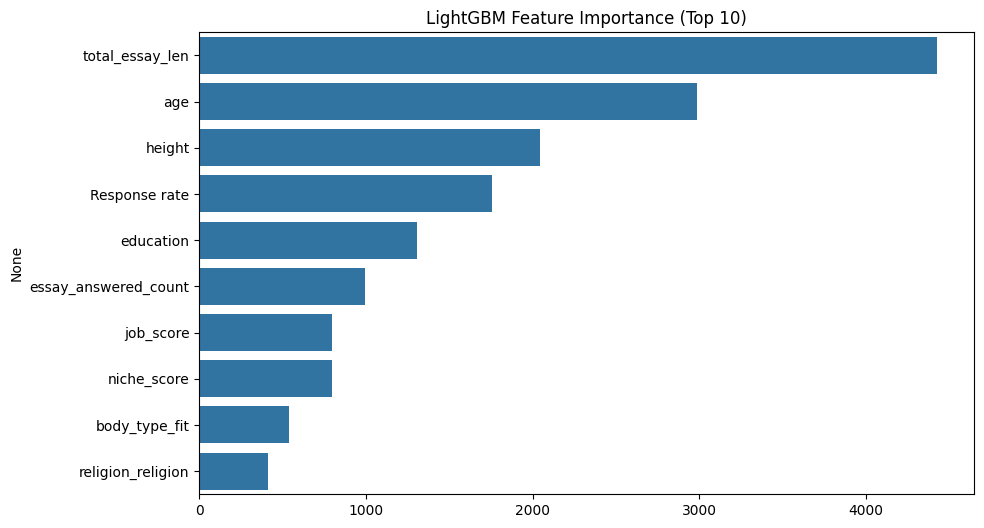

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# LightGBM의 특성 중요도 추출
feature_imp = pd.Series(best_lgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp.head(10).values, y=feature_imp.head(10).index)
plt.title('LightGBM Feature Importance (Top 10)')
plt.show()

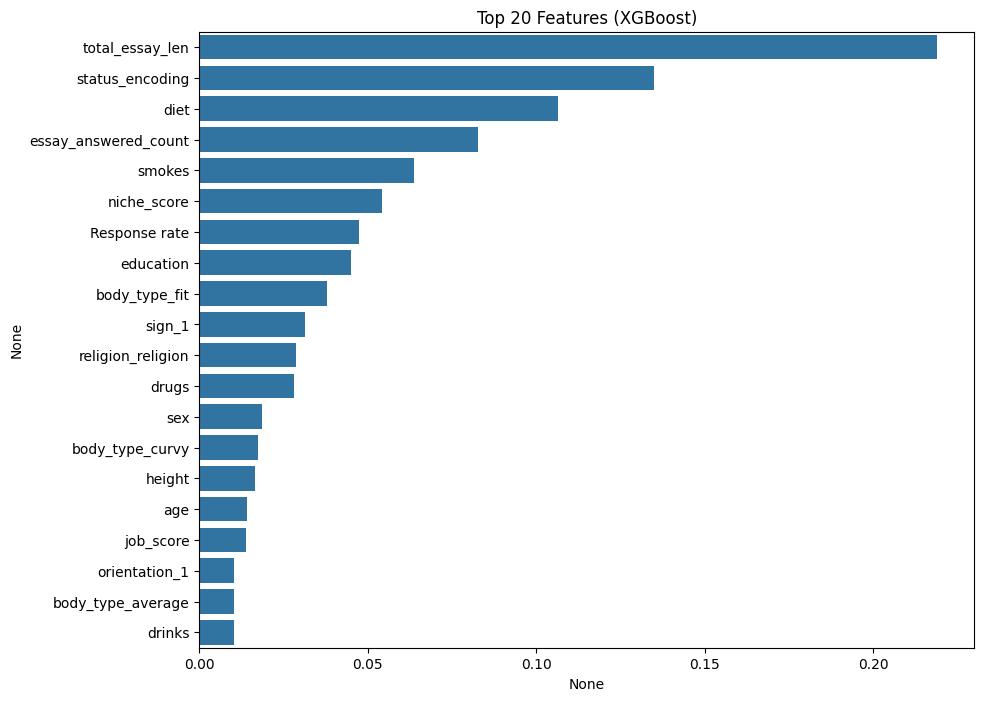

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# XGBoost 변수 중요도 시각화
ftr_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 8))
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.title('Top 20 Features (XGBoost)')
plt.show()

In [67]:
# 두 모델의 확률값을 평균 냄
xgb_probs = best_model.predict_proba(X_test)[:, 1]
lgbm_probs = best_lgb.predict_proba(X_test)[:, 1]

ensemble_probs = (xgb_probs + lgbm_probs) / 2

# 이 '앙상블 확률'로 다시 최적 임계값 찾기
precisions, recalls, thresholds = precision_recall_curve(y_test, ensemble_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
best_th_ens = thresholds[np.argmax(f1_scores)]

ensemble_preds = (ensemble_probs >= best_th_ens).astype(int)
print(f"앙상블 최적 임계값: {best_th_ens:.4f}")
print(classification_report(y_test, ensemble_preds))

앙상블 최적 임계값: 0.4877
              precision    recall  f1-score   support

           0       0.79      0.56      0.66      7983
           1       0.45      0.70      0.55      4004

    accuracy                           0.61     11987
   macro avg       0.62      0.63      0.60     11987
weighted avg       0.68      0.61      0.62     11987



In [68]:
# is_churned 구분하기
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# 1. 이탈자만 추출
churned_df = df[df['is_churned'] == 1].copy()

# 2. 핵심 변수: 설문 응답률, 에세이 길이, 니치 점수, 직업 점수
features = ['Response rate', 'total_essay_len', 'job_score', 'status_encoding', 'diet']
X_scaled = StandardScaler().fit_transform(churned_df[features])

# 3. GMM으로 3개 그룹 분류 (성공적 탈퇴 / 지쳐서 탈퇴 / 단순 변심)
gmm = GaussianMixture(n_components=2, random_state=42)
churned_df['churn_type'] = gmm.fit_predict(X_scaled)

# 4. 각 그룹의 평균값 확인
print(churned_df.groupby('churn_type')[features].mean())

            Response rate  total_essay_len  job_score  status_encoding  \
churn_type                                                               
0                0.865493      1863.947039   1.607062          0.88041   
1                0.815872      1630.589784   1.512373          0.89642   

                diet  
churn_type            
0           5.000000  
1           0.343206  


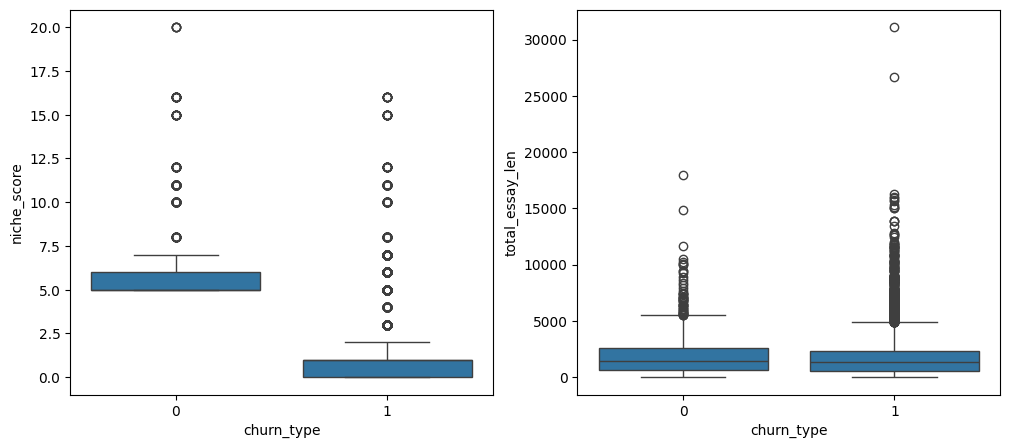

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# niche_score와 total_essay_len이 그룹을 나누는 핵심인지 확인
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='churn_type', y='niche_score', data=churned_df)
plt.subplot(1, 2, 2)
sns.boxplot(x='churn_type', y='total_essay_len', data=churned_df)
plt.show()

In [70]:
# 각 군집(0: 긍정 이탈 예상, 1: 부정 이탈 예상)의 유저 수 확인
group_counts = churned_df['churn_type'].value_counts()
group_percentages = churned_df['churn_type'].value_counts(normalize=True) * 100

print("--- [이탈자 군집별 인원수] ---")
print(group_counts)
print("\n--- [이탈자 군집별 비중 (%)] ---")
print(group_percentages)

--- [이탈자 군집별 인원수] ---
churn_type
1    18266
0     1756
Name: count, dtype: int64

--- [이탈자 군집별 비중 (%)] ---
churn_type
1    91.229647
0     8.770353
Name: proportion, dtype: float64


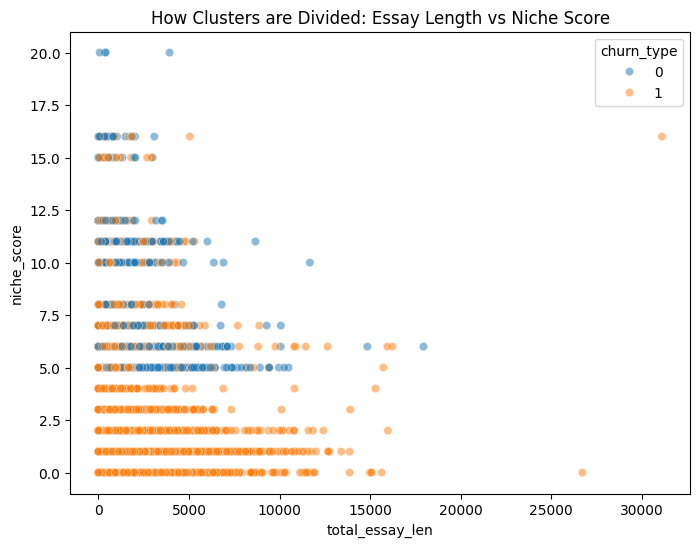

In [71]:
# 가장 차이가 큰 두 변수로 산점도 그리기
plt.figure(figsize=(8, 6))
sns.scatterplot(data=churned_df, x='total_essay_len', y='niche_score', hue='churn_type', alpha=0.5)
plt.title('How Clusters are Divided: Essay Length vs Niche Score')
plt.show()

In [72]:
from joblib import dump

In [73]:
## 모델 저장

dump(best_model, 'xgboost_model.joblib')

['xgboost_model.joblib']

In [74]:
dump(best_lgb, 'lgbm_model.joblib')

['lgbm_model.joblib']